In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv('train.csv')
dataset

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,7
1,4,4,4,4,4,4,5,5,5,6,...,4,4,4,4,4,4,4,4,4,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55995,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,7
55996,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,9
55997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
55998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [2]:
dataset.info()
dataset.isna().sum().unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Columns: 1025 entries, pix1 to label
dtypes: int64(1025)
memory usage: 437.9 MB


array([0])

In [3]:
(dataset.max() > 255).unique()

array([False])

In [4]:
(dataset.min() < 0).unique()

array([False])

In [5]:
dX = dataset.drop(columns=['label'])
images = [dX.loc[i].array.reshape((32, 32)) for i in range(min(len(dX), 6))]

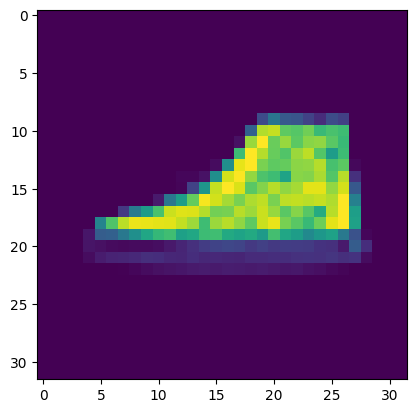

In [6]:
for img in images:
    plt.imshow(img)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['label']), dataset.label, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42) 

In [8]:
import torch
import torch.utils.data as data_utils
train_y = torch.tensor(y_train.values.astype(np.long))
train_x = torch.tensor(x_train.values.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train_x, train_y) 
trainloader = data_utils.DataLoader(dataset = train_tensor, batch_size = 32)

val_y = torch.tensor(y_val.values.astype(np.long))
val_x = torch.tensor(x_val.values.astype(np.float32)) 
val_tensor = data_utils.TensorDataset(val_x, val_y) 
validloader = data_utils.DataLoader(dataset = val_tensor, batch_size = 64)

test_y = torch.tensor(y_test.values.astype(np.long))
test_x = torch.tensor(x_test.values.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test_x, test_y) 
testloader = data_utils.DataLoader(dataset = test_tensor, batch_size = 64)

In [9]:
from torch import nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 784)
        self.fc2 = nn.Linear(784, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 100)
        self.fco = nn.Linear(100, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fco(x)
        return x
    
model = MLP()
for oneBatch in trainloader:
    inputs, labels = oneBatch
    outputs = model(inputs)

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()

loss = loss_fn(outputs, labels)
print('Total loss for this batch: {}'.format(loss.item()))

Total loss for this batch: 2.3025498390197754


In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [12]:
def train_one_epoch(model, loss_fn, optimizer, trainloader):
    running_cum_loss = 0.

    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]

    return running_cum_loss / len(x_train)

loss = train_one_epoch(model, loss_fn, optimizer, trainloader)
print(f"Celková trénovací chyba: {loss}")

Celková trénovací chyba: 1.0025760889337176


In [13]:
EPOCHS = 15

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    avg_loss = train_one_epoch(model, loss_fn, optimizer, trainloader)

    running_cum_vloss = 0.0
    vcorrect = 0
    for i, vdata in enumerate(validloader):
        vinputs, vlabels = vdata
        with torch.no_grad():
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
        running_cum_vloss += vloss * vinputs.shape[0]
        vcorrect += (voutputs.argmax(1) == vlabels).float().sum()

    avg_vloss = running_cum_vloss / len(x_val)
    vacc = vcorrect / len(x_val)
    
    print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuraccy: {vacc:.3f}")

EPOCH 1:
TRAIN loss: 0.786, VALIDATION loss: 0.771, accuraccy: 0.720
EPOCH 2:
TRAIN loss: 0.723, VALIDATION loss: 0.692, accuraccy: 0.724
EPOCH 3:
TRAIN loss: 0.670, VALIDATION loss: 0.624, accuraccy: 0.769
EPOCH 4:
TRAIN loss: 0.645, VALIDATION loss: 0.660, accuraccy: 0.757
EPOCH 5:
TRAIN loss: 0.631, VALIDATION loss: 0.624, accuraccy: 0.776
EPOCH 6:
TRAIN loss: 0.610, VALIDATION loss: 0.666, accuraccy: 0.758
EPOCH 7:
TRAIN loss: 0.618, VALIDATION loss: 0.612, accuraccy: 0.774
EPOCH 8:
TRAIN loss: 0.589, VALIDATION loss: 0.685, accuraccy: 0.751
EPOCH 9:
TRAIN loss: 0.597, VALIDATION loss: 0.589, accuraccy: 0.798
EPOCH 10:
TRAIN loss: 0.596, VALIDATION loss: 0.614, accuraccy: 0.791
EPOCH 11:
TRAIN loss: 0.609, VALIDATION loss: 0.615, accuraccy: 0.796
EPOCH 12:
TRAIN loss: 0.593, VALIDATION loss: 0.620, accuraccy: 0.784
EPOCH 13:
TRAIN loss: 0.599, VALIDATION loss: 0.808, accuraccy: 0.740
EPOCH 14:
TRAIN loss: 0.715, VALIDATION loss: 0.889, accuraccy: 0.714
EPOCH 15:
TRAIN loss: 0.741, 

In [14]:
test_predictions = np.zeros(len(x_test))
test_y = np.zeros(len(x_test))
print(test_predictions.shape)
ii = 0
for vdata in testloader:
    vinputs, vlabels = vdata
    with torch.no_grad():
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
    test_predictions[ii:(ii + vinputs.shape[0])] = voutputs.argmax(1).numpy()
    test_y[ii:(ii + vinputs.shape[0])] = vlabels.numpy()
    ii += vinputs.shape[0]

(11200,)


In [15]:
from sklearn.metrics import accuracy_score
print(f"Testovací přesnost: {accuracy_score(test_y, test_predictions)}")

Testovací přesnost: 0.7834821428571429
